<a href="https://colab.research.google.com/github/NamLucKing/Project/blob/master/PLANT_PATHOLOGY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Chuẩn bị thư viện

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import glob
import os.path as osp
import copy

from tqdm import tqdm
tqdm.pandas()

import pickle

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, models
from torchvision.utils import make_grid

import os
import time
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [ ]:
## Image Augmentation

# skimage
from skimage.io import imshow, imread, imsave
from skimage.transform import rotate, AffineTransform, warp,rescale, resize, downscale_local_mean
from skimage import color,data
from skimage.exposure import adjust_gamma
from skimage.util import random_noise


# 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors


#OpenCV-Python
import cv2

# imgaug
import imageio
import imgaug as ia
import imgaug.augmenters as iaa

SAMPLE_LEN=100

Data Reading, PreProcessing and Augmentation:

1. Thiết lập giá trị của các tham số cố định

In [ ]:
class Config:
    num_classes = 11
    img_size = 224
    batch_size = 64
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    min_lr = 10**-12
    max_lr = 10
    pretrained = False
    criterion = nn.CrossEntropyLoss()
    epochs = 30

2. Chuẩn bị dữ liệu

In [ ]:
train_dir = '/content/drive/MyDrive/Khóa Luận Tốt Nghiệp/train'
val_dir = '/content/drive/MyDrive/Khóa Luận Tốt Nghiệp/test'
test_dir = '/content/drive/MyDrive/Khóa Luận Tốt Nghiệp/test'

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Khóa Luận Tốt Nghiệp/train.csv")
df_sub = pd.read_csv("/content/drive/MyDrive/Khóa Luận Tốt Nghiệp/sample_submission.csv")

In [ ]:
batch_size = 32
img_size = 150

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                            width_shift_range=0.2,height_shift_range=0.2
                             )

val_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(val_dir,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical')

Found 13773 images belonging to 11 classes.
Found 33 images belonging to 11 classes.
Found 33 images belonging to 11 classes.


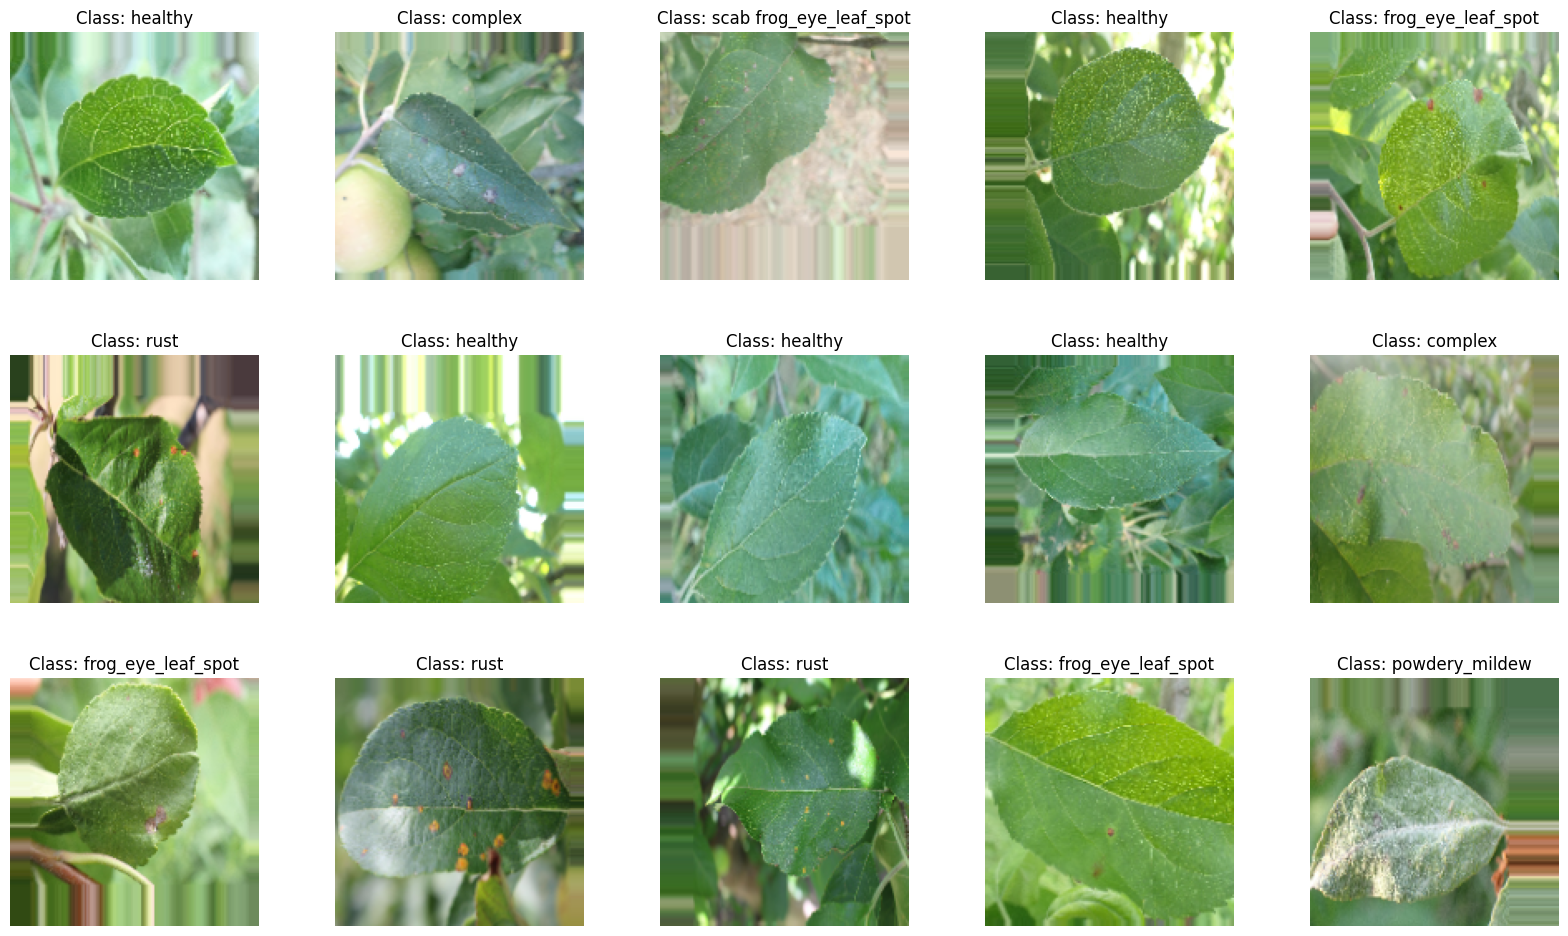

In [ ]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()

images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
# Xây dựng mô hình MobileNetV2
num_classes = 11
# Code to define the model
model = tf.keras.models.Sequential([
    # ADD LAYERS OF THE MODEL HERE
    tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=(224, 224,3),
                                                  pooling='avg', weights='imagenet'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])
model.layers[0].trainable = False

3. RGB Analysis

Histogram là một biểu diễn đồ họa cho biết tần suất xuất hiện của các giá trị màu khác nhau trong hình ảnh. Trong không gian màu RGB, các giá trị pixel nằm trong khoảng từ 0 đến 255 trong đó 0 là màu đen và 255 là màu trắng. Phân tích biểu đồ có thể giúp chúng ta hiểu được phân bố độ sáng, độ tương phản và cường độ của hình ảnh. Bây giờ chúng ta hãy xem biểu đồ của một mẫu được chọn ngẫu nhiên từ mỗi danh mục.

Phân phối Kênh Đỏ

In [ ]:
import numpy as np

# Replace this line with your actual red channel data
red_values = np.random.randn(100)

# Rest of your code remains the same
fig = ff.create_distplot([red_values], group_labels=["R"], colors=["red"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Phân phối Kênh Đỏ")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

Quan sát :
Các giá trị kênh màu đỏ có vẻ gần như phân phối chuẩn, nhưng hơi lệch về bên trái (Độ lệch âm). Điều này cho thấy rằng kênh màu đỏ có xu hướng tập trung nhiều hơn ở các giá trị cao hơn, vào khoảng 100. Có sự thay đổi lớn về giá trị màu đỏ trung bình trên các hình ảnh.

Phân phối Kênh Xanh Lá

In [ ]:
import numpy as np

# Replace this line with your actual green channel data
green_values = np.random.randn(100)

# Rest of your code remains the same
fig = ff.create_distplot([green_values], group_labels=["G"], colors=["green"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Phân phối Kênh Xanh Lá")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

Quan sát:
Giá trị kênh màu xanh lá cây có phân phối đồng đều hơn giá trị kênh màu đỏ nhưng lệch phải, với đỉnh nhỏ hơn. Sự phân bố cũng có độ lệch bên phải (trái ngược với màu đỏ) và chế độ lớn hơn khoảng 160. Điều này cho thấy rằng màu xanh lá cây rõ nét hơn trong những hình ảnh này so với màu đỏ, điều này có ý nghĩa, bởi vì đây là hình ảnh của những chiếc lá!

Phân phối Kênh Xanh Lam

In [ ]:
import numpy as np

# Replace this line with your actual blue channel data
blue_values = np.random.randn(100)

# Rest of your code remains the same
fig = ff.create_distplot([blue_values], group_labels=["B"], colors=["blue"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Phân phối Kênh Xanh Lam")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

Quan sát:
Kênh màu xanh lam có sự phân bố đồng đều nhất trong số ba kênh màu, với độ lệch tối thiểu (lệch một chút sang trái). Kênh màu xanh lam cho thấy sự thay đổi lớn giữa các hình ảnh trong tập dữ liệu.

Tổng hợp các kênh

In [ ]:
fig = go.Figure()

for idx, values in enumerate([red_values, green_values, blue_values]):
    if idx == 0:
        color = "Red"
    if idx == 1:
        color = "Green"
    if idx == 2:
        color = "Blue"
    fig.add_trace(go.Box(x=[color]*len(values), y=values, name=color, marker=dict(color=color.lower())))

fig.update_layout(yaxis_title="Mean value", xaxis_title="Color channel",
                  title="Mean value vs. Color channel", template="plotly_white")

In [ ]:
fig = ff.create_distplot([red_values, green_values, blue_values],
                         group_labels=["R", "G", "B"],
                         colors=["red", "green", "blue"])
fig.update_layout(title_text="Distribution of red channel values", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[2].marker.line.color = 'rgb(0, 0, 0)'
fig.data[2].marker.line.width = 0.5
fig

Kết luận

Phân tích kênh màu thì thấy kênh màu xanh chủ yếu có phân bố ở vùng có intensity mạnh ( vì nó tập trung ở phần cuối đồ thị) ==> Dễ hiểu vì ảnh toàn lá. Ví dụ như ảnh toàn lá mà thấy kênh màu đỏ lại mạnh hơn thì sẽ phát hiện bất thường. Ở đây kênh màu đỏ lại phân bố ở vùng giữa mạnh hơn kênh màu xanh dương, chứng tỏ màu đỏ nó cũng có xuất hiện nhiều là do một số lá cây bị sâu bênh hay có màu đỏ

4. Augumentation

In [ ]:
import albumentations as A
from albumentations import Compose
from albumentations.pytorch import ToTensorV2
import cv2

transform = {
    'train': Compose([
        A.Rotate(p=0.1, limit=(-85, 80)),
        A.RandomShadow(
            num_shadows_lower=2,
            num_shadows_upper=3,
            shadow_dimension=3,
            shadow_roi=(0, 0.7, 0.4, 0.8),
            p=0.4
        ),
        A.ShiftScaleRotate(
            shift_limit=0.055,
            scale_limit=0.065,
            rotate_limit=35,
            p=0.6
        ),
        A.RandomFog(
            fog_coef_lower=0.2,
            fog_coef_upper=0.2,
            alpha_coef=0.2,
            p=0.3
        ),
        A.RGBShift(
            r_shift_limit=25,
            g_shift_limit=15,
            b_shift_limit=15,
            p=0.3
        ),
        A.RandomBrightnessContrast(p=0.3),
        A.GaussNoise(
            var_limit=(50, 70),
            always_apply=False,
            p=0.3
        ),
        A.Resize(height=Config.img_size, width=Config.img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]),
    'val': Compose([
        A.Resize(Config.img_size, Config.img_size),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    'test': Compose([
        A.Resize(Config.img_size, Config.img_size),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
}

5.  Define new model

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
model_config = {
    "name": "2 FCs, 0.0001 Lr, 30 Epochs",
    "classifier": torch.nn.Sequential(
                  torch.nn.Linear(2048, 512),
                  torch.nn.Linear(512, 12)),
    "lr": 0.0001,
    "epoch": 30
}

In [ ]:
use_pretrained = True
pretrained_model = models.resnet50(pretrained=use_pretrained)

In [ ]:
name, classifier, lr, epoch = model_config.values()

pretrained_model.fc = classifier

print(f'Model name: {name}')
print(pretrained_model)

Model name: 2 FCs, 0.0001 Lr, 30 Epochs
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(

6. Huấn luyện và đánh giá model

6.1 Huấn luyện

In [ ]:
def plot_result(train_losses, train_accuracy, train_f1, val_losses, val_accuracy, val_f1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
    ax1.plot(train_losses, label='Train')
    ax1.plot(val_losses, label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(train_accuracy, label='Train')
    ax2.plot(val_accuracy, label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    ax3.plot(train_f1, label='Train')
    ax3.plot(val_f1, label='Validation')
    ax2.set_title('F1 Score')
    ax3.legend()

6.2 Train model

In [ ]:
def append_list(list, appended):
    for el in appended:
        list.append(el)
    return list

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=Config.epochs):

    train_losses = []
    train_accuracy = []
    train_f1 = []

    val_losses = []
    val_accuracy = []
    val_f1 = []

    print(f"Devices to be used : {Config.device}")
    model.to(Config.device)
    torch.backends.cudnn.benchmark = True

    start_time = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            epoch_targets = []
            epoch_predictions = []

            # Iterate over data.
            for i, data in tqdm(enumerate(dataloaders_dict[phase]), total=len(dataloaders_dict[phase])):
#                 inputs = np.transpose(data[0]['image'], (0, 3, 1, 2))
                inputs = data[0]['image']
                labels = data[1]
                inputs = inputs.to(Config.device)
                labels = labels.to(Config.device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                np_preds = preds.cpu().data.numpy()
                np_labels = labels.cpu().data.numpy()
                append_list(epoch_predictions, np_preds)
                append_list(epoch_targets, np_labels)

                batch_f1 = f1_score(preds.cpu().data.numpy(), labels.cpu().data.numpy(), average='weighted')

#                 if i % 50 == 0 and i != 0:
#                 print(f'Batch: {i}  |  Loss: {loss.item():.4f}   |   F1-score: {batch_f1:.4f}%')

            epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders_dict[phase].dataset)

            epoch_f1 = f1_score(epoch_predictions, epoch_targets, average='weighted')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracy.append(epoch_acc)
                train_f1.append(epoch_f1)
            else:
                val_losses.append(epoch_loss)
                val_accuracy.append(epoch_acc)
                val_f1.append(epoch_f1)

            print('{} Loss: {:.4f} Acc: {:.4f} F1_score: {:.4f}'.format('----> ' + phase.capitalize(), epoch_loss, epoch_acc, epoch_f1))

    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

    plot_result(train_losses, train_accuracy, train_f1, val_losses, val_accuracy, val_f1)

    return model

In [ ]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Huấn luyện mô hình
history =model.fit(train_generator,batch_size=512, epochs=15, validation_data=validation_generator)

Epoch 1/15
431/431 [==============================] - 1238s 3s/step - loss: 1.0867 - accuracy: 0.6500 - val_loss: 2.6210 - val_accuracy: 0.3333
Epoch 2/15
431/431 [==============================] - 1193s 3s/step - loss: 1.0701 - accuracy: 0.6556 - val_loss: 2.3410 - val_accuracy: 0.3939
Epoch 3/15
431/431 [==============================] - 1326s 3s/step - loss: 1.0789 - accuracy: 0.6512 - val_loss: 2.1055 - val_accuracy: 0.3939
Epoch 4/15
431/431 [==============================] - 1185s 3s/step - loss: 1.0514 - accuracy: 0.6620 - val_loss: 2.2792 - val_accuracy: 0.4242
Epoch 5/15
431/431 [==============================] - 1173s 3s/step - loss: 1.0661 - accuracy: 0.6593 - val_loss: 2.2229 - val_accuracy: 0.3939
Epoch 6/15
431/431 [==============================] - 1178s 3s/step - loss: 1.0663 - accuracy: 0.6539 - val_loss: 2.4349 - val_accuracy: 0.4545
Epoch 7/15
431/431 [==============================] - 1205s 3s/step - loss: 1.0718 - accuracy: 0.6548 - val_loss: 1.9390 - val_accuracy:

6.3 Save model

In [ ]:
trained_model = ...

name = "my_model"

save_model(trained_model, name)


In [ ]:
def save_model(model, filename):
    Pkl_Filename = name + ".pkl"

    with open(Pkl_Filename, 'wb') as file:
        pickle.dump(model, file)

save_model(trained_model, name)

7. Make prediction

7.1 Create pridictor

In [ ]:
class PlantPredictor():

    def __init__(self, model, df_labels_idx, dataloaders_dict):
        self.model = model
        self.df_labels_idx = df_labels_idx
        self.dataloaders_dict = dataloaders_dict
        self.df_submit = pd.DataFrame()


    def __predict_max(self, out):

        maxid = np.argmax(out.detach().numpy(), axis=1)
        df_predicted_label_name = self.df_labels_idx.iloc[maxid]

        return df_predicted_label_name

    def inference(self):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        df_pred_list = []
        for i, data in enumerate(self.dataloaders_dict['test']):
            image_name = data[2]
            self.model.to(device)
            inputs = data[0]['image']
            inputs = inputs.to(device)
            out = self.model(inputs)
            device = torch.device("cpu")
            out = out.to(device)
            df_pred = self.__predict_max(out).reset_index(drop=True)
            df_pred["image"] = image_name
            df_pred_list.append(df_pred)

        self.df_submit = pd.concat(df_pred_list, axis=0)
        self.df_submit = self.df_submit[["image", "labels"]].reset_index(drop=True)

7.2 Make submission

In [ ]:
def inference(self):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model.to(device)

    df_pred_list = []

    for i, data in enumerate(self.dataloaders_dict['test']):
        images, labels, image_names = data  # Assuming the structure is (images, labels, image_names)
        inputs = images.to(device)

        with torch.no_grad():
            out = self.model(inputs)

        df_pred = self.__predict_max(out).reset_index(drop=True)
        df_pred["image"] = image_names
        df_pred_list.append(df_pred)

    self.df_submit = pd.concat(df_pred_list, axis=0)
    self.df_submit = self.df_submit[["image", "labels"]].reset_index(drop=True)
